
# PyTorch Lightning CIFAR10 ~94% Baseline Tutorial

* **Author:** Lightning.ai
* **License:** CC BY-SA
* **Generated:** 2024-09-01T12:43:52.217738

Train a Resnet to 94% accuracy on Cifar10!


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/cifar10-baseline.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://lightning.ai/docs/)
| Join us [on Discord](https://discord.com/invite/tfXFetEZxv)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "matplotlib" "numpy <3.0" "pytorch-lightning >=2.0,<2.5" "torchmetrics>=1.0, <1.5" "seaborn" "torch>=1.8.1, <2.5" "pandas" "torchvision"

In [2]:
# Run this if you intend to use TPUs
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [3]:
import os

import pandas as pd
import pytorch_lightning as pl
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import display
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10

pl.seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

Seed set to 7


### CIFAR10 DataLoaders


In [4]:

cifar10_normalization = torchvision.transforms.Normalize(
    mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
    std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
)


def split_dataset(dataset, val_split=0.2, train=True):
    """Splits the dataset into train and validation set."""
    len_dataset = len(dataset)
    splits = get_splits(len_dataset, val_split)
    dataset_train, dataset_val = random_split(dataset, splits, generator=torch.Generator().manual_seed(42))

    if train:
        return dataset_train
    return dataset_val


def get_splits(len_dataset, val_split):
    """Computes split lengths for train and validation set."""
    if isinstance(val_split, int):
        train_len = len_dataset - val_split
        splits = [train_len, val_split]
    elif isinstance(val_split, float):
        val_len = int(val_split * len_dataset)
        train_len = len_dataset - val_len
        splits = [train_len, val_len]
    else:
        raise ValueError(f"Unsupported type {type(val_split)}")

    return splits


train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization,
    ]
)
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization,
    ]
)

dataset_train = CIFAR10(PATH_DATASETS, train=True, download=True, transform=train_transforms)
dataset_val = CIFAR10(PATH_DATASETS, train=True, download=True, transform=test_transforms)
dataset_train = split_dataset(dataset_train)
dataset_val = split_dataset(dataset_val, train=False)
dataset_test = CIFAR10(PATH_DATASETS, train=False, download=True, transform=test_transforms)

train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 229376/170498071 [00:00<01:30, 1878945.44it/s]

  1%|          | 1998848/170498071 [00:00<00:16, 10393585.66it/s]

  4%|▍         | 6946816/170498071 [00:00<00:05, 27333811.88it/s]

  7%|▋         | 11829248/170498071 [00:00<00:04, 35553953.35it/s]

 10%|▉         | 16678912/170498071 [00:00<00:03, 40071712.20it/s]

 13%|█▎        | 21528576/170498071 [00:00<00:03, 42807699.06it/s]

 16%|█▌        | 26443776/170498071 [00:00<00:03, 44798961.56it/s]

 18%|█▊        | 31358976/170498071 [00:00<00:03, 46160115.13it/s]

 21%|██        | 36208640/170498071 [00:00<00:02, 46799548.34it/s]

 24%|██▍       | 41025536/170498071 [00:01<00:02, 47164759.80it/s]

 27%|██▋       | 45776896/170498071 [00:01<00:02, 43314562.45it/s]

 30%|██▉       | 50855936/170498071 [00:01<00:02, 45387939.12it/s]

 33%|███▎      | 55771136/170498071 [00:01<00:02, 46457647.93it/s]

 36%|███▌      | 60620800/170498071 [00:01<00:02, 47023583.38it/s]

 38%|███▊      | 65470464/170498071 [00:01<00:02, 47423100.32it/s]

 41%|████      | 70320128/170498071 [00:01<00:02, 47661590.13it/s]

 44%|████▍     | 75169792/170498071 [00:01<00:01, 47893869.23it/s]

 47%|████▋     | 80019456/170498071 [00:01<00:01, 48026203.37it/s]

 50%|████▉     | 84869120/170498071 [00:01<00:01, 48082261.92it/s]

 53%|█████▎    | 89686016/170498071 [00:02<00:01, 48044031.23it/s]

 55%|█████▌    | 94535680/170498071 [00:02<00:01, 48125871.14it/s]

 58%|█████▊    | 99385344/170498071 [00:02<00:01, 48178212.86it/s]

 61%|██████    | 104235008/170498071 [00:02<00:01, 48154020.62it/s]

 64%|██████▍   | 109084672/170498071 [00:02<00:01, 48169516.07it/s]

 67%|██████▋   | 113934336/170498071 [00:02<00:01, 47198505.22it/s]

 70%|██████▉   | 118685696/170498071 [00:02<00:01, 44474872.53it/s]

 72%|███████▏  | 123207680/170498071 [00:02<00:01, 44674805.85it/s]

 75%|███████▍  | 127729664/170498071 [00:02<00:01, 41905389.78it/s]

 77%|███████▋  | 131989504/170498071 [00:03<00:00, 39960465.35it/s]

 80%|███████▉  | 136052736/170498071 [00:03<00:00, 37410866.70it/s]

 82%|████████▏ | 139853824/170498071 [00:03<00:00, 34465057.58it/s]

 84%|████████▍ | 143360000/170498071 [00:03<00:00, 32771466.65it/s]

 86%|████████▌ | 146702336/170498071 [00:03<00:00, 31738966.37it/s]

 88%|████████▊ | 149913600/170498071 [00:03<00:00, 31133220.57it/s]

 90%|████████▉ | 153059328/170498071 [00:03<00:00, 30829847.63it/s]

 92%|█████████▏| 156172288/170498071 [00:03<00:00, 28796783.23it/s]

 93%|█████████▎| 159088640/170498071 [00:04<00:00, 26022600.49it/s]

 95%|█████████▍| 161742848/170498071 [00:04<00:00, 22394559.06it/s]

 96%|█████████▌| 164102144/170498071 [00:04<00:00, 18113741.71it/s]

 97%|█████████▋| 166100992/170498071 [00:04<00:00, 15680073.43it/s]

 98%|█████████▊| 167837696/170498071 [00:04<00:00, 14461412.06it/s]

 99%|█████████▉| 169377792/170498071 [00:04<00:00, 13648292.25it/s]

100%|██████████| 170498071/170498071 [00:04<00:00, 34436116.22it/s]

Extracting /__w/13/s/.datasets/cifar-10-python.tar.gz to /__w/13/s/.datasets


Files already downloaded and verified


Files already downloaded and verified


### Resnet
Modify the pre-existing Resnet architecture from TorchVision. The pre-existing architecture is based on ImageNet
images (224x224) as input. So we need to modify it for CIFAR10 images (32x32).

In [5]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

### Lightning Module
Check out the [`configure_optimizers`](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#configure-optimizers)
method to use custom Learning Rate schedulers. The OneCycleLR with SGD will get you to around 92-93% accuracy
in 20-30 epochs and 93-94% accuracy in 40-50 epochs. Feel free to experiment with different
LR schedules from https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [6]:
class LitResnet(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [7]:
model = LitResnet(lr=0.05)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1,
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step")],
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
trainer.test(model, dataloaders=test_dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Missing logger folder: logs/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8141999840736389
        test_loss           0.5329769253730774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5329769253730774, 'test_acc': 0.8141999840736389}]

,lr-SGD,test_acc,test_loss,train_loss,val_acc,val_loss
epoch,,,,,,
NaN,0.012079,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,1.818587,NaN,NaN
NaN,0.034132,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,1.639136,NaN,NaN
NaN,0.062440,NaN,NaN,NaN,NaN,NaN


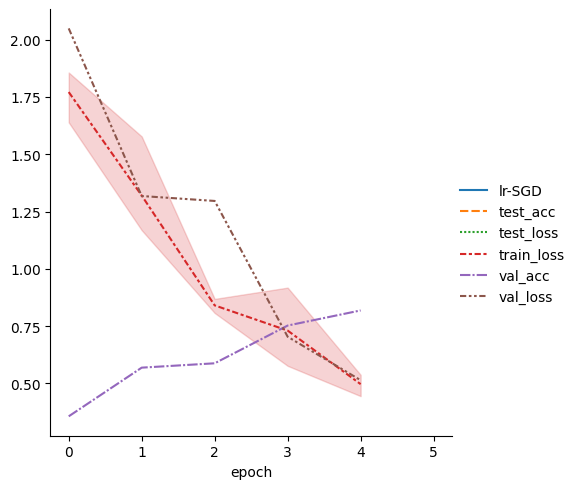

In [8]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

### Bonus: Use [Stochastic Weight Averaging](https://arxiv.org/abs/1803.05407) to get a boost on performance

Use SWA from torch.optim to get a quick performance boost. Also shows a couple of cool features from Lightning:
- Use `training_epoch_end` to run code after the end of every epoch
- Use a pretrained model directly with this wrapper for SWA

In [9]:
class SWAResnet(LitResnet):
    def __init__(self, trained_model, lr=0.01):
        super().__init__()

        self.save_hyperparameters("lr")
        self.model = trained_model
        self.swa_model = AveragedModel(self.model)

    def forward(self, x):
        out = self.swa_model(x)
        return F.log_softmax(out, dim=1)

    def on_train_epoch_end(self):
        self.swa_model.update_parameters(self.model)

    def validation_step(self, batch, batch_idx, stage=None):
        x, y = batch
        logits = F.log_softmax(self.model(x), dim=1)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.hparams.lr, momentum=0.9, weight_decay=5e-4)
        return optimizer

    # def on_train_end(self):  # todo: failing as trainer has only dataloaders, not datamodules
    #     update_bn(self.trainer.datamodule.train_dataloader(), self.swa_model, device=self.device)

In [10]:
swa_model = SWAResnet(model.model, lr=0.01)

swa_trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1,
    logger=CSVLogger(save_dir="logs/"),
)

swa_trainer.fit(swa_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
swa_trainer.test(swa_model, dataloaders=test_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'trained_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['trained_model'])`.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | ResNet        | 11.2 M | train
1 | swa_model | AveragedModel | 11.2 M | train
----------------------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
89.392    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8141999840736389
        test_loss           0.5329769253730774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5329769253730774, 'test_acc': 0.8141999840736389}]

,lr-SGD,test_acc,test_loss,train_loss,val_acc,val_loss
epoch,,,,,,
NaN,0.012079,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,1.818587,NaN,NaN
NaN,0.034132,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,1.639136,NaN,NaN
NaN,0.062440,NaN,NaN,NaN,NaN,NaN


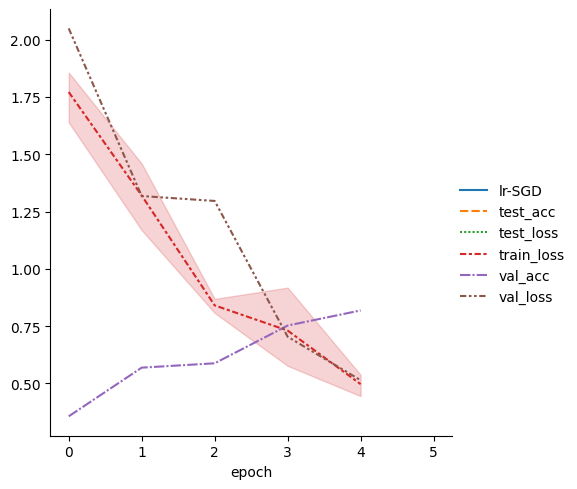

In [11]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Discord](https://discord.com/invite/tfXFetEZxv)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)